In [0]:
!pip install torch 

    100% |████████████████████████████████| 591.8MB 31kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x6142c000 @  0x7f3c8de2f2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
# Load zip from Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
!unzip gdrive/My\ Drive/data_semantics.zip

In [0]:
!tar -xvzf gdrive/My\ Drive/iccv09Data.tar.gz

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [0]:
class InitialBlock(nn.Module):
    def __init__ (self,in_channels = 3,out_channels = 13):
        super().__init__()


        self.maxpool = nn.MaxPool2d(kernel_size=2, 
                                      stride = 2, 
                                      padding = 0)

        self.conv = nn.Conv2d(in_channels, 
                                out_channels,
                                kernel_size = 3,
                                stride = 2, 
                                padding = 1)

        self.prelu = nn.PReLU()

        self.batchnorm = nn.BatchNorm2d(out_channels)
  
    def forward(self, x):
        
        main = self.conv(x)
        main = self.batchnorm(main)
        main = self.prelu(main)
        
        side = self.maxpool(x)
        
        x = torch.cat((main, side), dim=1)
        
        return x

In [0]:
sample = torch.rand((1, 3, 512, 512))
inet = InitialBlock()
out = inet(sample)
out.shape

torch.Size([1, 3, 512, 512]) <class 'torch.Tensor'>


torch.Size([1, 16, 256, 256])

In [0]:
class UBNeck(nn.Module):
    def __init__(self, h, w, in_channels, out_channels, p=0.01):
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.h = h
        self.w = w
        
        self.unpool = nn.MaxUnpool2d(kernel_size = 2)
        
        
        self.main_conv = nn.Conv2d(in_channels = self.in_channels,
                                           out_channels = self.out_channels,
                                           kernel_size = 1)
        
        self.dropout = nn.Dropout2d(p=p)
        
        self.convt1 = nn.ConvTranspose2d(in_channels = self.in_channels,
                               out_channels = self.out_channels,
                               kernel_size = 1,
                               padding = 0,
                               bias = False)
        
        
        self.prelu1 = nn.PReLU()
        
        self.convt2 = nn.ConvTranspose2d(in_channels = self.out_channels,
                                  out_channels = self.out_channels,
                                  kernel_size = 3,
                                  stride = 2,
                                  padding = 1,
                                  output_padding = 1,
                                  bias = True)
        
        self.prelu2 = nn.PReLU()
        
        self.convt3 = nn.ConvTranspose2d(in_channels = self.out_channels,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  padding = 0,
                                  bias = False)
        
        self.prelu3 = nn.PReLU()
        
        self.batchnorm = nn.BatchNorm2d(self.out_channels)
        
    def forward(self, x, indices):
        x_copy = x.clone()
        
        # Side Branch
        x = self.convt1(x)
        x = self.batchnorm(x)
        x = self.prelu1(x)
        
        x = self.convt2(x)
        x = self.batchnorm(x)
        x = self.prelu2(x)
        
        x = self.convt3(x)
        x = self.batchnorm(x)
        
        x = self.dropout(x)
        
        # Main Branch
        
        x_copy = self.main_conv(x_copy)
        x_copy = self.unpool(x_copy, indices, output_size=x.size())
        
        # Concat
        x = x + x_copy
        x = self.prelu3(x)
        
        return x

In [0]:
sample = torch.rand((1, 128, 64, 64))
inet = UBNeck(64, 64, 128, 64)
out = inet(sample)
out.shape

TypeError: ignored

In [0]:
class RDDNeck(nn.Module):
    def __init__(self, h, w, dilate, in_channels, out_channels, down_flag, p=0.1):
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.h = h
        self.w = w
        self.dilate = dilate
        self.down_flag = down_flag

        if down_flag:
            self.stride = 2
        else:
            self.stride = 1
          
        
        self.maxpool = nn.MaxPool2d(kernel_size = 2,
                                      stride = 2,
                                      padding = 0, return_indices=True)
        

        
        self.dropout = nn.Dropout2d(p=p)
        
        self.conv1 = nn.Conv2d(in_channels = self.in_channels,
                               out_channels = self.out_channels,
                               kernel_size = 1,
                               stride = 1,
                               padding = 0,
                               bias = False,
                               dilation = 1)
        
        self.prelu1 = nn.PReLU()
        
        self.conv2 = nn.Conv2d(in_channels = self.out_channels,
                                  out_channels = self.out_channels,
                                  kernel_size = 3,
                                  stride = self.stride,
                                  padding = self.dilate,
                                  bias = True,
                                  dilation = self.dilate)
        
        self.prelu2 = nn.PReLU()
        
        self.conv3 = nn.Conv2d(in_channels = self.out_channels,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  stride = 1,
                                  padding = 0,
                                  bias = False,
                                  dilation = 1)
        
        self.prelu3 = nn.PReLU()
        
        self.batchnorm = nn.BatchNorm2d(self.out_channels)
        
    def forward(self, x):
        
        bs = x.size()[0]
        x_copy = x.clone()
        
        # Side Branch
        x = self.conv1(x)
        x = self.batchnorm(x)
        x = self.prelu1(x)
        
        x = self.conv2(x)
        x = self.batchnorm(x)
        x = self.prelu2(x)
        
        x = self.conv3(x)
        x = self.batchnorm(x)
                
        x = self.dropout(x)
        
        # Main Branch
        
        if self.down_flag:
            x_copy, indices = self.maxpool(x_copy)
          
        if self.in_channels != self.out_channels:
            out_shape = self.out_channels - self.in_channels
            extras = torch.zeros((bs, out_shape, x.shape[2], x.shape[3]))
            if torch.cuda.is_available:
                extras = extras.cuda()
            x_copy = torch.cat((x_copy, extras), dim = 1)
        
        # Sum of main and side branches
        x = x + x_copy
        x = self.prelu3(x)
        
        if self.down_flag:
            return x, indices
        else:
            return x

In [0]:
sample = torch.rand((1, 64, 256, 256))
inet = RDDNeck(256, 256, 1, 64, 64, False)
out = inet(sample)
out.shape

torch.Size([1, 64, 256, 256])


torch.Size([1, 64, 256, 256])

In [0]:
class ASNeck(nn.Module):
    def __init__(self, h, w, in_channels, out_channels, p=0.01):
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.h = h
        self.w = w
        
        self.dropout = nn.Dropout2d(p=p)
        
        self.conv1 = nn.Conv2d(in_channels = self.in_channels,
                               out_channels = self.out_channels,
                               kernel_size = 1,
                               stride = 1,
                               padding = 0,
                               bias = False)
        
        self.prelu1 = nn.PReLU()
        
        self.conv21 = nn.Conv2d(in_channels = self.out_channels,
                                  out_channels = self.out_channels,
                                  kernel_size = (1, 5),
                                  stride = 1,
                                  padding = (0, 2),
                                  bias = True)
        
        self.conv22 = nn.Conv2d(in_channels = self.out_channels,
                                  out_channels = self.out_channels,
                                  kernel_size = (5, 1),
                                  stride = 1,
                                  padding = (2, 0),
                                  bias = True)
        
        self.prelu2 = nn.PReLU()
        
        self.conv3 = nn.Conv2d(in_channels = self.out_channels,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  stride = 1,
                                  padding = 0,
                                  bias = False)
        
        self.prelu3 = nn.PReLU()
        
        self.batchnorm = nn.BatchNorm2d(self.out_channels)
        
    def forward(self, x):
        bs = x.size()[0]
        x_copy = x.clone()
        
        # Side Branch
        x = self.conv1(x)
        x = self.batchnorm(x)
        x = self.prelu1(x)
        
        x = self.conv21(x)
        x = self.conv22(x)
        x = self.batchnorm(x)
        x = self.prelu2(x)
        
        x = self.conv3(x)
        x = self.batchnorm(x)
                
        x = self.dropout(x)
        
        # Main Branch
        
        if self.in_channels != self.out_channels:
            out_shape = self.out_channels - self.in_channels
            extras = torch.zeros((bs, out_shape, x.shape[2], x.shape[3]))
            if torch.cuda.is_available:
                extras = extras.cuda()
            x_copy = torch.cat((x_copy, extras), dim = 1)
        
        # Sum of main and side branches
        x = x + x_copy
        x = self.prelu3(x)
        
        return x

In [0]:
sample = torch.rand((1, 64, 256, 256))
inet = ASNeck(256, 256, 64, 128)
out = inet(sample)
out.shape

torch.Size([1, 64, 256, 256]) torch.Size([1, 64, 256, 256])
torch.Size([1, 128, 256, 256]) torch.Size([1, 128, 256, 256])


torch.Size([1, 128, 256, 256])

In [0]:
class ENet(nn.Module):
    def __init__(self, C):
        super().__init__()
        
        # Define class variables
        self.C = C
        
        self.init = InitialBlock()
        
        self.b10 = RDDNeck(256, 256, 1, 16, 64, True, 0.01)
        self.b11 = RDDNeck(128, 128, 1, 64, 64, False, 0.01)
        self.b12 = RDDNeck(128, 128, 1, 64, 64, False, 0.01)
        self.b13 = RDDNeck(128, 128, 1, 64, 64, False, 0.01)
        self.b14 = RDDNeck(128, 128, 1, 64, 64, False, 0.01)
        
        self.b20 = RDDNeck(128, 128, 1, 64, 128, True)
        self.b21 = RDDNeck(64, 64, 1, 128, 128, False)
        self.b22 = RDDNeck(64, 64, 2, 128, 128, False)
        self.b23 = ASNeck(64, 64, 128, 128)
        self.b24 = RDDNeck(64, 64, 4, 128, 128, False)
        self.b25 = RDDNeck(64, 64, 1, 128, 128, False)
        self.b26 = RDDNeck(64, 64, 8, 128, 128, False)
        self.b27 = ASNeck(64, 64, 128, 128)
        self.b28 = RDDNeck(64, 64, 16, 128, 128, False)
        
        self.b31 = RDDNeck(64, 64, 1, 128, 128, False)
        self.b32 = RDDNeck(64, 64, 2, 128, 128, False)
        self.b33 = ASNeck(64, 64, 128, 128)
        self.b34 = RDDNeck(64, 64, 4, 128, 128, False)
        self.b35 = RDDNeck(64, 64, 1, 128, 128, False)
        self.b36 = RDDNeck(64, 64, 8, 128, 128, False)
        self.b37 = ASNeck(64, 64, 128, 128)
        self.b38 = RDDNeck(64, 64, 16, 128, 128, False)
        
        self.b40 = UBNeck(64, 64, 128, 64)
        self.b41 = RDDNeck(128, 128, 1, 64, 64, False)
        self.b42 = RDDNeck(128, 128, 1, 64, 64, False)
        
        self.b50 = UBNeck(128, 128, 64, 16)
        self.b51 = RDDNeck(256, 256, 1, 16, 16, False)
        
        self.fullconv = nn.ConvTranspose2d(in_channels=16, 
                                           out_channels=self.C, 
                                           kernel_size=3, 
                                           stride=2, 
                                           padding=1, 
                                           output_padding=1)
        
        
    def forward(self, x):
        
        x = self.init(x)
        
        x, i1 = self.b10(x)
        x = self.b11(x)
        x = self.b12(x)
        x = self.b13(x)
        x = self.b14(x)
        
        x, i2 = self.b20(x)
        x = self.b21(x)
        x = self.b22(x)
        x = self.b23(x)
        x = self.b24(x)
        x = self.b25(x)
        x = self.b26(x)
        x = self.b27(x)
        x = self.b28(x)
        
        x = self.b31(x)
        x = self.b32(x)
        x = self.b33(x)
        x = self.b34(x)
        x = self.b35(x)
        x = self.b36(x)
        x = self.b37(x)
        x = self.b38(x)
        
        x = self.b40(x, i2)
        x = self.b41(x)
        x = self.b42(x)
        
        x = self.b50(x, i1)
        x = self.b51(x)
        
        x = self.fullconv(x)
        x = nn.functional.sigmoid(x)
        
        return x

In [0]:
sample = torch.rand((1, 3, 512, 512))
inet = ENet(10)
out = inet(sample)
out.shape

torch.Size([1, 10, 512, 512])

In [0]:
simg = plt.imread('./training/semantic_rgb/000059_10.png')

In [0]:
def create_mask(img):
  color_map = [
    (  0,  0,  0) ,
    (111, 74,  0) ,
    ( 81,  0, 81) ,
    (128, 64,128) ,
    (244, 35,232) ,
    (250,170,160) ,
    (230,150,140),
    ( 70, 70, 70) ,
    (102,102,156) ,
    (190,153,153),
    (180,165,180) ,
    (150,100,100) ,
    (150,120, 90) ,
    (153,153,153) ,
    (250,170, 30),
    (220,220,  0),
    (107,142, 35),
    (152,251,152),
    ( 70,130,180),
    (220, 20, 60),
    (255,  0,  0),
    (  0,  0,142),
    (  0,  0, 70),
    (  0, 60,100),
    (  0,  0, 90),
    (  0,  0,110),
    (  0, 80,100),
    (  0,  0,230),
    (119, 11, 32)
]

def craete_mask(img, color_map):
  mask = []
  for i in color_map:
    color_img = []
    for j in range(3):
      color_img.append(np.ones((img.shape[:-1])) * i[j]) 
    
    img2 = np.array(color_img, dtype=np.uint8).transpose(1, 2, 0)
    
    mask.append(np.uint8((img == img2).sum(axis = -1) == 3))
  return np.array(mask)

In [8]:

_mask = create_mask(img4, color_map)

NameError: ignored

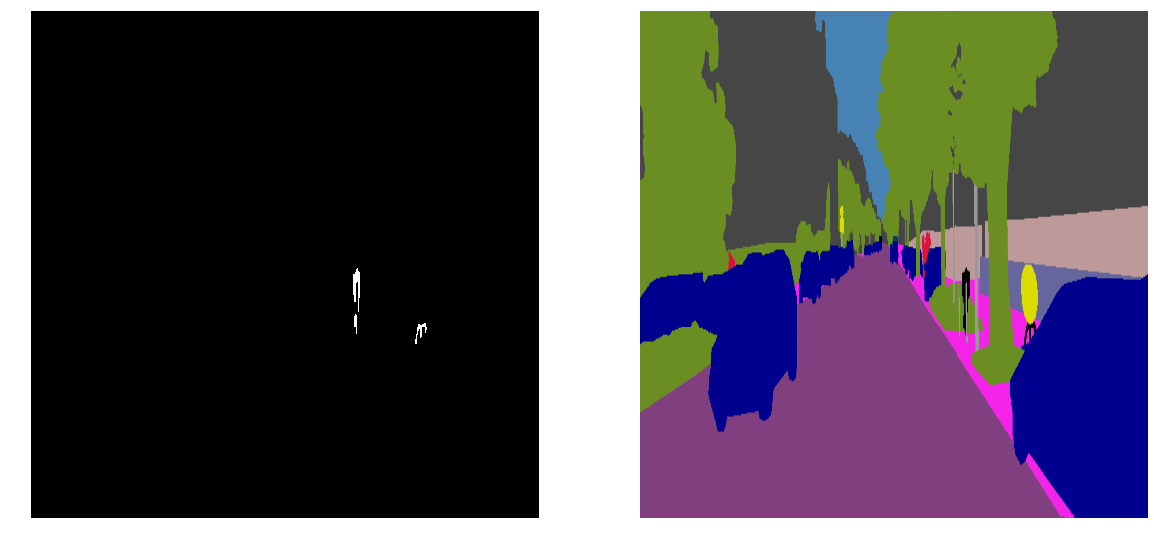

In [0]:
fig = plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(1 - _mask[0, :, :])
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(img4)
plt.show()

In [0]:
a[1, 1, :]

array([ 35, 142, 107], dtype=uint8)

In [0]:
def read_resized_imgs(ImageDirPath,Semantic_flag):
  os.chdir(ImageDirPath)
  for i in os.listdir():
    if '.png' in i:
      img = cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB)
      img = cv2.cvtColor(cv2.resize(img,(512,512), cv2.INTER_CUBIC), 
                         cv2.COLOR_BGR2RGB)
      images.append(img)
      
  if Semantic_flag:
    images = list(map(create_mask, images))
    
  return np.array(images)
      

In [0]:
resize_path = '/content/resized_images/'

In [0]:
save_resized_imgs('/content/training/image_2/', resize_path)

In [0]:
!rm -rf /content/sm_rz_img/

In [0]:
img1 = plt.imread('/content/training/image_2/000000_10.png')
img2 = plt.imread('/content/resized_images/000000_10_resized.png')
img3 = cv2.imread('/content/training/semantic_rgb/000000_10.png')
img4 = plt.imread('/content/sm_rz_img/000000_10_resized.png')

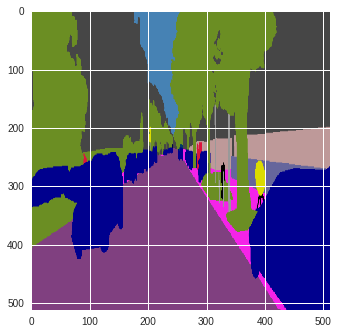

In [0]:
a = cv2.resize(img3, (512,512), cv2.INTER_CUBIC)
plt.imshow(a)
cv2.imwrite('/content/o.png', a)
b = cv2.cvtColor(cv2.imread('/content/o.png'), cv2.COLOR_BGR2RGB)
plt.imshow(b)

In [0]:
fig = plt.figure(figsize=(40, 10))
plt.subplot(4, 1, 1)
plt.axis('off')
plt.imshow(img1)
plt.subplot(4, 1, 2)
plt.axis('off')
plt.imshow(img3)
plt.subplot(4, 1, 3)
plt.axis('off')
plt.imshow(img2)
plt.subplot(4, 1, 4)
plt.axis('off')
plt.imshow(img4)
#plt.imshow(cv2.resize(img3, (512,512), cv2.INTER_NEAREST))

In [0]:
import os
len(os.listdir('./training/image_2/'))

200

In [0]:
os.chdir('../../')

In [0]:
!rm -rf ./training/semantic_rgb/sm_rz_img/

In [0]:
img2_ = torch.from_numpy(img2)
img2_ = img2_.unsqueeze(0)
img2_ = torch.transpose(img2_, 1, 3)
img2_.shape

torch.Size([1, 3, 512, 512])

In [0]:
enet = ENet(29)
a = enet(img2_)
a.shape

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([1, 29, 512, 512])

In [0]:
_mask = create_mask(img4, color_map)
_mask1 = _mask.astype(np.float32)
_mask = torch.tensor(_mask).unsqueeze(0)
_mask.shape

torch.Size([1, 29, 512, 512])

In [0]:
criterion(torch.autograd.Variable(a.squeeze()), torch.autograd.Variable(torch.tensor(_mask1)))

tensor(0.6718)

In [0]:

TrainDataObj = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(TrainLabels))
TestDataObj = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(TestLabels))
trainloader = DataLoader(TrainDataObj, batch_size=16,
                        shuffle=True, num_workers=4)
testloader = DataLoader(TestDataObj, batch_size=16,
                        shuffle=True, num_workers=4)

NameError: ignored

In [0]:
enet = ENet(29)

In [0]:
epochs =500
lr = 0.01

In [0]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(enet.parameters(), lr=lr)

In [0]:
trainloader = loader('./training/image_2/', './training/semantic_rgb/', 4)

In [0]:
cuda =  torch.cuda.is_available()

print_every = 10
train_losses = []


if cuda:
    enet.cuda()
    
enet.train()

for e in range(epochs):
    
    trainloader = loader('./training/image_2/', './training/semantic_rgb/', 4)
    print (e)
    
    for inputs, labels in trainloader:
        if cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
            
        out = enet(inputs)
        
        enet.zero_grad()
        
        loss = criterion(out, labels.float())
        loss.backward()
        optimizer.step()
        
        
        train_losses.append(loss)
        
        print ('.', end='')
    
    print ()
    
    if e+1 % print_every == 0:
        
        print ('Epoch {}/{}...'.format(e+1, epochs),
               'Loss {:6f}'.format(loss))

In [0]:
enet.eval()

for inputs, labels in testloader:
    if cuda:
        inputs, labels = inputs.cuda(), labels.cuda()

    out = enet(inputs)

    enet.zero_grad()

    loss = criterion(inputs, labels)
    loss.backward()
    optimizer.step()


    train_losses.append(loss)

    if print_every % e == 0:
        print ('Epoch {}/{}'.format(e, epochs),
               'Loss {}'.format(loss))

In [0]:
def loader(training_path, segmented_path, batch_size):
    filenames_t = os.listdir(training_path)
    total_files_t = len(filenames_t)
    
    filenames_s = os.listdir(segmented_path)
    total_files_s = len(filenames_s)
    
    assert(total_files_t == total_files_s)
    
    iterations = (total_files_t // batch_size) + 1 if total_files_t % batch_size != 0 else (total_files_t // batch_size)
    idx = 0
    for ii in range(iterations):
        new_idx = idx + batch_size if idx+batch_size < total_files_t else total_files_t
        inputs = []
        labels = []
        
        for jj in range(idx, new_idx):
            img = plt.imread(training_path + filenames_t[jj])
            img = cv2.resize(img, (512, 512), cv2.INTER_CUBIC)
            inputs.append(img)
            
            img = cv2.imread(segmented_path + filenames_s[jj])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (512, 512), cv2.INTER_NEAREST)
            mask = create_mask(img, color_map)
            labels.append(mask)
         
        inputs = np.stack(inputs, axis=2)
        inputs = torch.tensor(inputs).transpose(0, 2).transpose(1, 3)
        
        labels = torch.tensor(labels)
        
        yield inputs, labels
        
        idx = new_idx

In [0]:
gen = loader('./training/image_2/', './training/semantic_rgb/', 4)
gen = iter(gen)
inputs, labels = next(gen)
labels.shape, inputs.shape

6


(torch.Size([6, 29, 512, 512]), torch.Size([6, 3, 512, 512]))

In [0]:
i1 = labels[4]
i1[4].shape

torch.Size([512, 512])

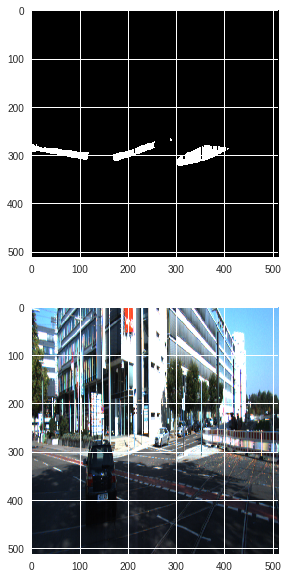

In [0]:
figure = plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plt.imshow(1 - labels[4][4, :, :])
plt.subplot(2, 1, 2)
plt.imshow(inputs[4].transpose(0, 1).transpose(1, 2))

In [0]:
labels[2][21, 100, 100]

tensor(0, dtype=torch.uint8)

In [118]:
tmg_ = plt.imread('./training/image_2/000006_10.png')
tmg_ = cv2.resize(tmg_, (512, 512), cv2.INTER_CUBIC)
tmg = torch.tensor(tmg_).unsqueeze(0)
tmg = tmg.transpose(2, 3).transpose(1, 2).cuda()
tmg.shape

torch.Size([1, 3, 512, 512])

In [119]:
out1 = enet(tmg).squeeze(0)

RuntimeError: ignored

In [98]:
torch.round_(out1)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

In [0]:
torch.max(out1[7, :, :])

tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)

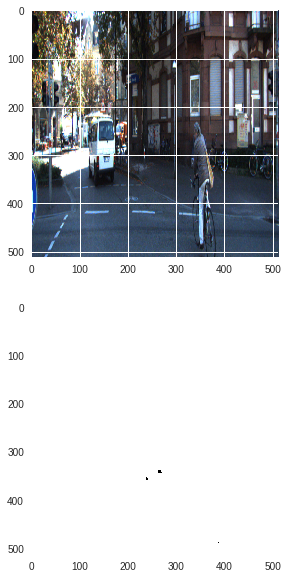

In [112]:
figure = plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plt.imshow(tmg_)
plt.subplot(2, 1, 2)
plt.imshow(out1[5, :, :].cpu().detach().numpy())

In [0]:
out1[0, :, :].cpu().detach().numpy().shape

(512, 512)

In [0]:
oo1 = out1[0, :, :]
oo1.shape

torch.Size([1, 29, 512, 512])

In [0]:
out1.shape

torch.Size([1, 1, 29, 512, 512])